In [1]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

from ahrs.filters import Madgwick, Mahony

In [2]:
ANNOTATION_DIR = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\gold_annotation"

In [3]:
MOTION = "SWING_RIGHT"

In [4]:
file_pattern = os.path.join(ANNOTATION_DIR, "*.csv")
csv_files = glob.glob(file_pattern)
print(len(csv_files))
df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)

8


In [5]:
# Keeps values equal to 'SPECIFIC_MOTION', changes everything else to 'NOT_SPECIFIC_MOTION'
df['motion_type'] = df['motion_type'].where(df['motion_type'] == f'{MOTION}', f'NOT_{MOTION}')

In [6]:
len(df)

269

In [7]:
df.head()

,gyro_x_0,gyro_y_0,gyro_z_0,accel_x_0,accel_y_0,accel_z_0,gyro_x_1,gyro_y_1,gyro_z_1,accel_x_1,...,accel_x_4,accel_y_4,accel_z_4,gyro_x_5,gyro_y_5,gyro_z_5,accel_x_5,accel_y_5,accel_z_5,motion_type
0,0.094428,-0.720844,0.777013,0.89025,-12.843750,-2.612513,0.00000,0.000000,0.000000,0.00000,...,3.879000,-3.748950,-8.397000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_SWING_RIGHT
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.05885,-0.298650,0.524517,5.39300,...,-76.785004,70.759056,21.894001,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_SWING_RIGHT
2,0.073253,-0.283078,0.453750,4.65600,-12.122776,-1.741500,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_SWING_RIGHT
3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-2.06723,-0.871613,-6.555670,-12.05658,...,0.027000,-3.603000,3.202950,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NOT_SWING_RIGHT
4,0.000000,0.000000,0.000000,4.27395,-34.944000,-38.773052,0.65890,11.824312,-11.209413,6.69300,...,5.471475,-6.936975,-1.344000,0.109587,0.174694,0.17435,6.108525,-8.61555,-2.526975,NOT_SWING_RIGHT


In [8]:
def ahrs_transform(gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z):
    gyro_data = np.array([[gyro_x, gyro_y, gyro_z]])
    accel_data = np.array([[accel_x, accel_y, accel_z]])
    orientation = Mahony(gyr=gyro_data, acc=accel_data)
    return orientation.Q[0][0], orientation.Q[0][1], orientation.Q[0][2], orientation.Q[0][3]

In [9]:
for i in range(6):
    df[[f"ahrs_x_{i}", f"ahrs_y_{i}", f"ahrs_z_{i}", f"ahrs_w_{i}"]] = df.apply(lambda row: ahrs_transform(
        row[f"gyro_x_{i}"],
        row[f"gyro_y_{i}"],
        row[f"gyro_z_{i}"],
        row[f"accel_x_{i}"],
        row[f"accel_y_{i}"],
        row[f"accel_z_{i}"]
        ), axis=1, result_type="expand")

In [10]:
df = df.loc[:, ~df.columns.str.startswith("gyro")]
df = df.loc[:, ~df.columns.str.startswith("accel")]

In [11]:
df.head()

,motion_type,ahrs_x_0,ahrs_y_0,ahrs_z_0,ahrs_w_0,ahrs_x_1,ahrs_y_1,ahrs_z_1,ahrs_w_1,ahrs_x_2,...,ahrs_z_3,ahrs_w_3,ahrs_x_4,ahrs_y_4,ahrs_z_4,ahrs_w_4,ahrs_x_5,ahrs_y_5,ahrs_z_5,ahrs_w_5
0,NOT_SWING_RIGHT,0.632358,-0.773934,-0.021451,-0.026254,1.000000,0.000000,0.000000,0.000000,1.000000,...,-0.041321,-0.193910,0.204278,-0.958625,-0.041321,-0.193910,1.000000,0.000000,0.000000,0.000000
1,NOT_SWING_RIGHT,1.000000,0.000000,0.000000,0.000000,0.623231,-0.758098,-0.121941,-0.148329,0.623231,...,0.314686,-0.232037,0.740788,0.546227,0.314686,-0.232037,1.000000,0.000000,0.000000,0.000000
2,NOT_SWING_RIGHT,0.644131,-0.743277,-0.118309,-0.136519,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,NOT_SWING_RIGHT,1.000000,0.000000,0.000000,0.000000,0.655179,0.483188,0.467392,-0.344697,0.655179,...,-0.002555,-0.001147,0.912245,-0.409634,-0.002555,-0.001147,1.000000,0.000000,0.000000,0.000000
4,NOT_SWING_RIGHT,0.358285,-0.932718,-0.014644,-0.038123,0.377380,-0.903657,-0.078020,-0.186822,0.377380,...,-0.205862,-0.249574,0.602094,-0.729943,-0.205862,-0.249574,0.572854,-0.765006,-0.176394,-0.235562


<Axes: xlabel='motion_type', ylabel='count'>

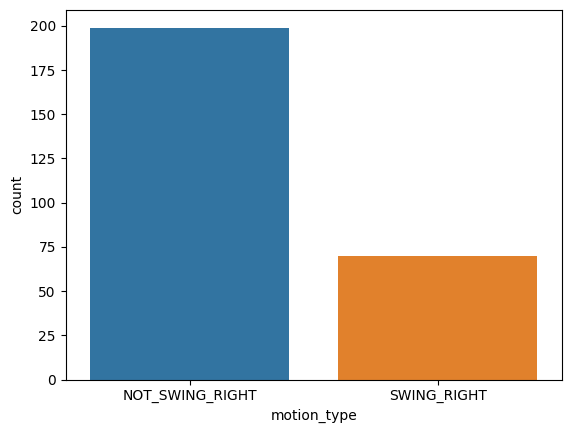

In [12]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [13]:
X_df = df.drop(columns=["motion_type"])
y = df["motion_type"].values

In [14]:
n_timesteps = 6
channels = ["ahrs_x", "ahrs_y", "ahrs_z", "ahrs_w"]
n_channels = len(channels)

X = np.zeros((len(df), n_channels, n_timesteps))

for t in range(n_timesteps):
    for c, channel in enumerate(channels):
        col_name = f"{channel}_{t}"
        X[:, c, t] = X_df[col_name].values

In [15]:
def left_zero_pad(X, target_timesteps=9):
    """
    X shape: (n_samples, n_channels, n_timesteps)
    """
    n_samples, n_channels, n_timesteps = X.shape
    pad = target_timesteps - n_timesteps

    if pad <= 0:
        return X

    padding = np.zeros((n_samples, n_channels, pad))
    X_padded = np.concatenate([padding, X], axis=2)
    return X_padded

In [16]:
X = left_zero_pad(X, target_timesteps=9)
print(X.shape)  # (n_samples, 6, 9)

(269, 4, 9)


In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.33, random_state=42)

In [19]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline

In [20]:
clf_minirocket = make_pipeline(
    MiniRocketMultivariate(random_state=42),
    RidgeClassifier(alpha=1.0)
)
# clf_minirocket = KNeighborsTimeSeriesClassifier(n_neighbors=1)
# clf_minirocket = InceptionTimeClassifier()

clf_minirocket.fit(X_train, y_train)

,steps,"[('minirocketmultivariate', ...), ('ridgeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,class_weight,None
,solver,'auto'


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clf_minirocket.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7303370786516854
0.38461538461538464
0.5555555555555556
0.45454545454545453


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [24]:
precision_macro = make_scorer(
    precision_score, average="macro", zero_division=0
)

recall_macro = make_scorer(
    recall_score, average="macro", zero_division=0
)

f1_macro = make_scorer(
    f1_score, average="macro", zero_division=0
)

In [25]:
scores_accuracy = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring="accuracy"
)

scores_precision = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=precision_macro
)

scores_recall = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=recall_macro
)

scores_f1 = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=f1_macro
)

In [26]:
print("MiniRocket Accuracy :", scores_accuracy.mean(), "±", scores_accuracy.std())
print("MiniRocket Precision:", scores_precision.mean(), "±", scores_precision.std())
print("MiniRocket Recall   :", scores_recall.mean(), "±", scores_recall.std())
print("MiniRocket F1-score :", scores_f1.mean(), "±", scores_f1.std())

MiniRocket Accuracy : 0.85359477124183 ± 0.029039032537938617
MiniRocket Precision: 0.7699999999999999 ± 0.04988876515698587
MiniRocket Recall   : 0.7576190476190476 ± 0.10081751998338835
MiniRocket F1-score : 0.755558923834786 ± 0.07161948227288233


In [27]:
%%timeit
clf_minirocket.predict(np.expand_dims(X[0], axis=0))

29.5 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


KNeighborsTimeSeriesClassifier (Euclidean)
3.48 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

KNeighborsTimeSeriesClassifier (DTW)
15.8 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

InceptionTimeClassifier
83 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)